# Maintenance Log Analysis: From Notes to Prevention


In [1]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import io
import plotly.express as px

# Set styles
sns.set(style="whitegrid")

In [23]:
# Load Data
from google.colab import files
uploaded = files.upload()

Saving cleaned_abnormality_report (1).csv to cleaned_abnormality_report (1) (1).csv


In [26]:
df = pd.read_csv(io.BytesIO(uploaded['cleaned_abnormality_report (1) (1).csv']))
df.head()

,Abnormality_ID,MaintenanceProblemCode,Problem Description,Employee_Name,SafetyIssue,MachineDownNew,Date_Created,DateClosed,Action Owner,MachineHoursLost,TotalHoursToClose,Maint Tech Notes/Abnormality Action Item Notes
0,45557.0,Alarm Machine Down,Telescopic cover opened,64db4c8a67,No,No,2016-03-04 09:08:15,2016-03-04 10:20:41,cba0ba69c9,0.0,1.2,done
1,46292.0,Door Issue,Door interlock key broken.,f5eec0c0aa,Yes,Yes,2016-05-04 22:55:03,2016-05-13 23:26:54,49b43321e6,140.1,216.5,S no 237566\nE500\nfound the door interlock ke...
2,46986.0,Alarms Machine not Down,"Tool change at the time ATC ALARAM,(292 No Too...",2f42bc8acf,No,No,2016-06-13 12:26:37,2016-06-13 14:29:31,3de2e22f41,0.0,2.1,found the tool detect sensor dirty sensor clea...
3,47229.0,Alarm Machine Down,"Appeared 209 Slidway lube malfunction alarm, n...",200c10adb1,No,Yes,2016-06-24 10:38:29,2016-06-24 12:58:15,967727c350,2.3,2.3,Grease top up and reset.\n\n!2:15-12:45P.M
4,47914.0,Door Issue,Machine Door interlock Key locking & unlocking...,3ece55ca19,Yes,No,2016-08-01 09:03:51,2016-08-03 12:05:42,967727c350,0.0,51.0,0Interlock key and head replaced and checked O...


### Preprocessing

In [27]:
df['SafetyIssueBool'] = df['SafetyIssue'].str.lower() == 'yes'
df['MachineDownBool'] = df['MachineDownNew'].str.lower() == 'yes'
df['Notes'] = df['Maint Tech Notes/Abnormality Action Item Notes'].fillna("")

In [28]:
df['NoteLength'] = df['Notes'].apply(lambda x: len(x.split()))

### Exploratory Data Analysis

<ipython-input-12-2c6036d1f256>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Avg. Machine Hours Lost", "Safety Issue Rate (%)"],
<ipython-input-12-2c6036d1f256>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_problem_codes.values, y=top_problem_codes.index, palette="viridis")
<ipython-input-12-2c6036d1f256>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='MachineDownBool', y='MachineHoursLost', data=df, palette="coolwarm")


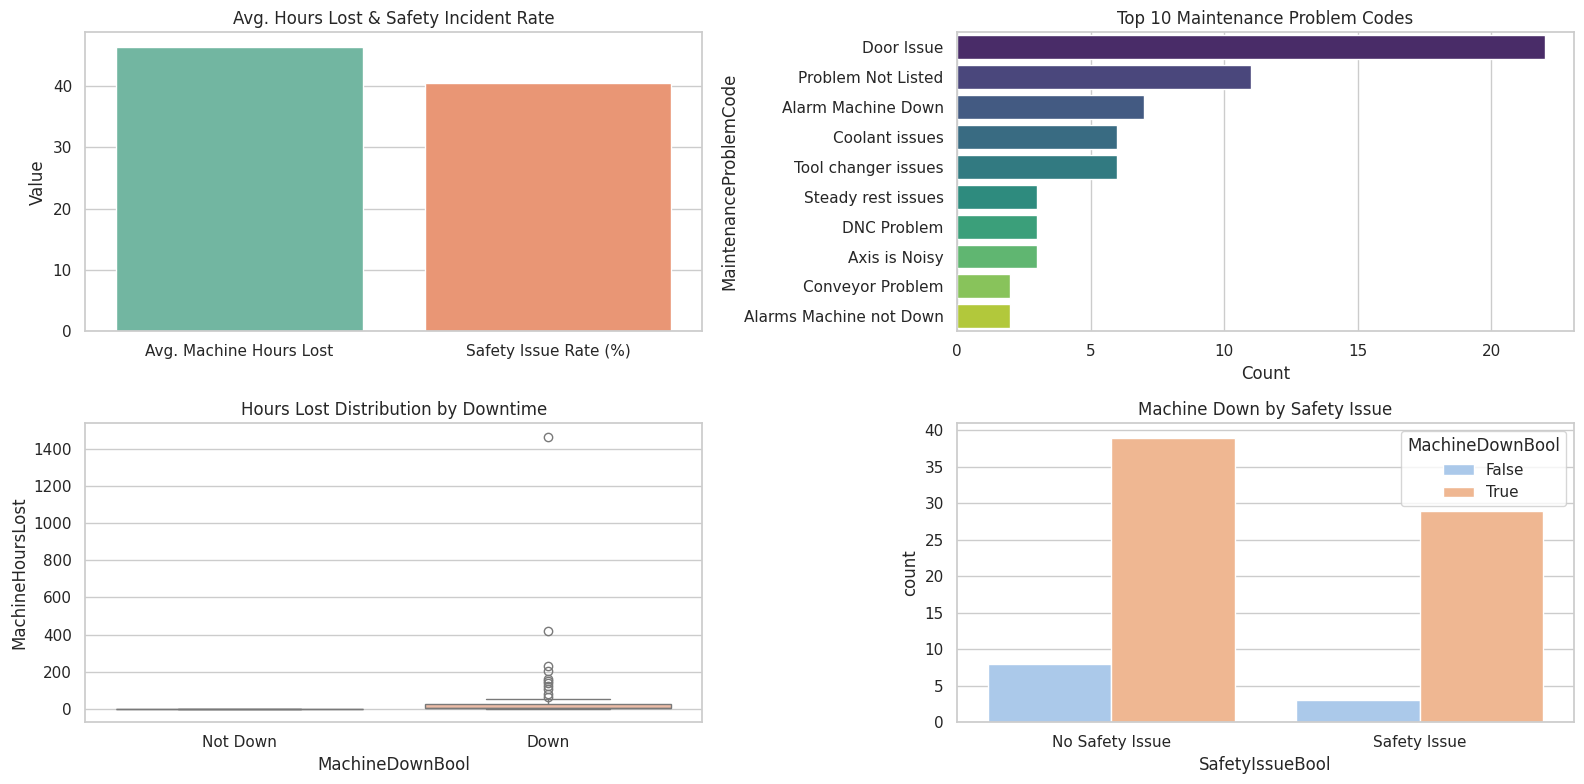

In [12]:
plt.figure(figsize=(16, 8))

avg_hours_lost = df['MachineHoursLost'].mean()
safety_issue_rate = df['SafetyIssueBool'].mean()

plt.subplot(2, 2, 1)
sns.barplot(x=["Avg. Machine Hours Lost", "Safety Issue Rate (%)"],
            y=[avg_hours_lost, safety_issue_rate * 100],
            palette="Set2")
plt.ylabel("Value")
plt.title("Avg. Hours Lost & Safety Incident Rate")

plt.subplot(2, 2, 2)
top_problem_codes = df['MaintenanceProblemCode'].value_counts().nlargest(10)
sns.barplot(x=top_problem_codes.values, y=top_problem_codes.index, palette="viridis")
plt.xlabel("Count")
plt.title("Top 10 Maintenance Problem Codes")

plt.subplot(2, 2, 3)
sns.boxplot(x='MachineDownBool', y='MachineHoursLost', data=df, palette="coolwarm")
plt.xticks([0, 1], ['Not Down', 'Down'])
plt.title("Hours Lost Distribution by Downtime")

plt.subplot(2, 2, 4)
sns.countplot(x='SafetyIssueBool', hue='MachineDownBool', data=df, palette='pastel')
plt.xticks([0, 1], ['No Safety Issue', 'Safety Issue'])
plt.title("Machine Down by Safety Issue")

plt.tight_layout()
plt.show()

### Word Clouds

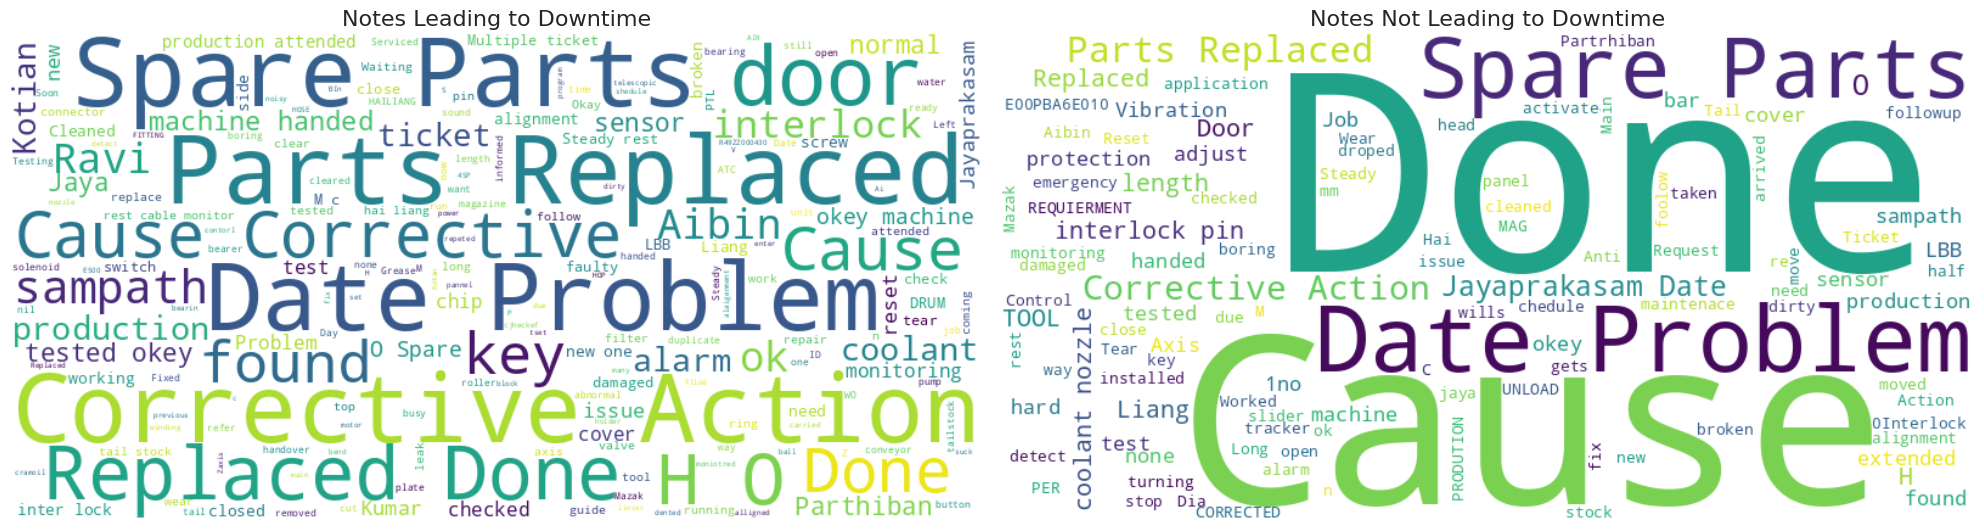

In [13]:
notes_downtime = " ".join(df[df['MachineDownBool']]['Notes'])
notes_not_downtime = " ".join(df[~df['MachineDownBool']]['Notes'])

wordcloud_down = WordCloud(width=800, height=400, background_color='white').generate(notes_downtime)
wordcloud_not_down = WordCloud(width=800, height=400, background_color='white').generate(notes_not_downtime)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(wordcloud_down, interpolation='bilinear')
axes[0].set_title('Notes Leading to Downtime', fontsize=16)
axes[0].axis('off')

axes[1].imshow(wordcloud_not_down, interpolation='bilinear')
axes[1].set_title('Notes Not Leading to Downtime', fontsize=16)
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Simple Predictive Model - Downtime

In [ ]:
vectorizer = CountVectorizer(max_features=300, stop_words='english')
X = vectorizer.fit_transform(df['Notes']).toarray()
y = df['MachineDownBool']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

       False       0.00      0.00      0.00         6
        True       0.88      1.00      0.94        44

    accuracy                           0.88        50
   macro avg       0.44      0.50      0.47        50
weighted avg       0.77      0.88      0.82        50

Confusion Matrix:
 [[ 0  6]
 [ 0 44]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
top_abnormalities = df.groupby("MaintenanceProblemCode")["MachineHoursLost"]\
                      .sum().sort_values(ascending=False).head(5)

fig = px.bar(top_abnormalities[::-1],  # reverse for horizontal order
             x=top_abnormalities.values,
             y=top_abnormalities.index,
             orientation='h',
             labels={'x': 'Total Machine Hours Lost', 'y': 'Maintenance Problem Code'},
             title="Top 5 Maintenance Problem Codes by Downtime")

fig.update_layout(yaxis=dict(autorange="reversed"))
fig.show()


In [32]:
import plotly.graph_objects as go

# Pick top 2 outliers
top_outliers = df.nlargest(2, "MachineHoursLost")

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df['Abnormality_ID'],
    y=df['MachineHoursLost'],
    mode='markers',
    marker=dict(size=6, color='gray'),
    name='Incidents'
))

fig.add_trace(go.Scatter(
    x=top_outliers['Abnormality_ID'],
    y=top_outliers['MachineHoursLost'],
    mode='markers+text',
    marker=dict(size=10, color='red'),
    text=top_outliers['MaintenanceProblemCode'],
    textposition="top center",
    name='Outliers'
))

fig.update_layout(title="MachineHoursLost vs. Abnormality ID (Outliers Highlighted)",
                  xaxis_title="Abnormality ID",
                  yaxis_title="Machine Hours Lost")
fig.show()


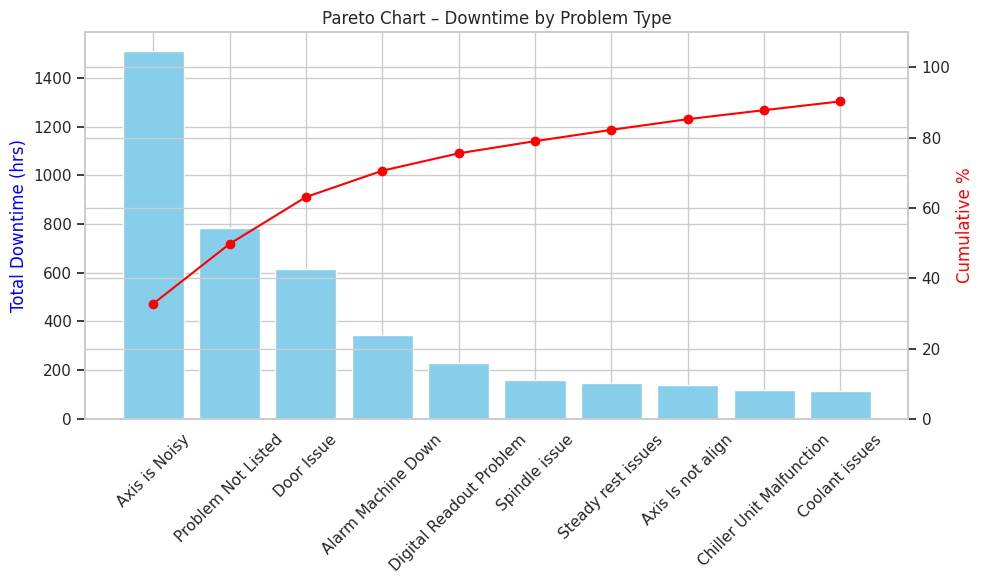

In [29]:
# Group and sort
problem_downtime = df.groupby("MaintenanceProblemCode")["MachineHoursLost"]\
                     .sum().sort_values(ascending=False)

# Pareto values
cum_sum = problem_downtime.cumsum()
cum_perc = cum_sum / cum_sum.max() * 100

fig, ax1 = plt.subplots(figsize=(10,6))

# Bar plot
ax1.bar(problem_downtime.index[:10], problem_downtime.values[:10], color='skyblue')
ax1.set_ylabel('Total Downtime (hrs)', color='blue')
ax1.tick_params(axis='x', rotation=45)

# Line plot on twin axis
ax2 = ax1.twinx()
ax2.plot(problem_downtime.index[:10], cum_perc[:10], color='red', marker='o')
ax2.set_ylabel('Cumulative %', color='red')
ax2.set_ylim(0, 110)

plt.title("Pareto Chart – Downtime by Problem Type")
plt.tight_layout()
plt.show()


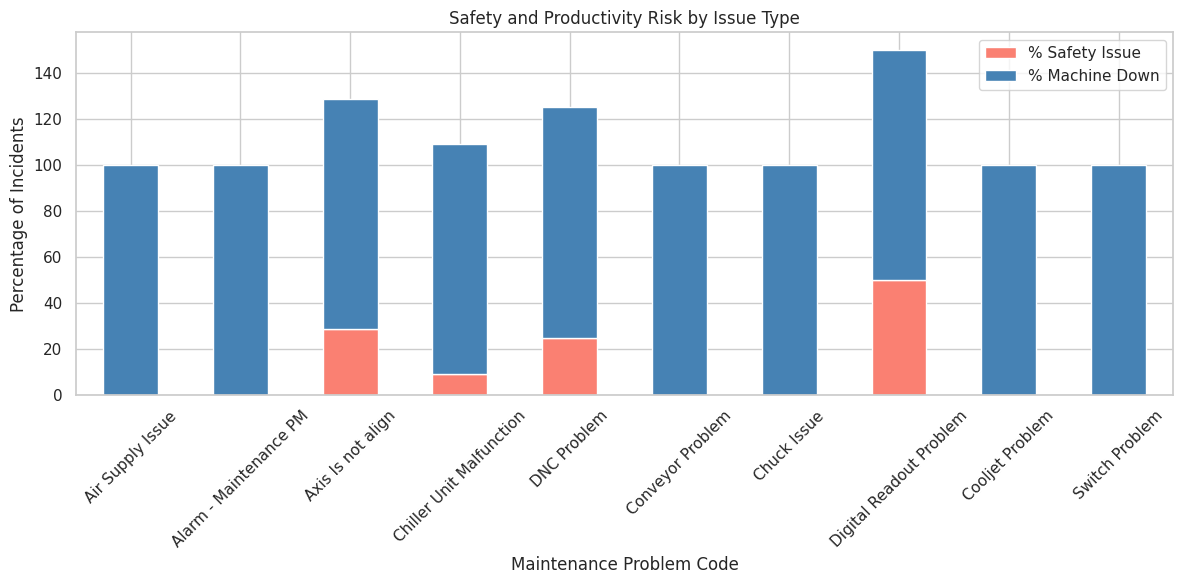

In [38]:
# Step 1: Calculate proportions
counts = (
    df.groupby("MaintenanceProblemCode")[["SafetyIssueBool", "MachineDownBool"]]
    .mean()
    .sort_values(by="MachineDownBool", ascending=False)
    .head(10)  # focus on top 10
    * 100  # convert to percentages
)

# Step 2: Plot stacked bar chart
ax = counts.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    color=["salmon", "steelblue"]
)
plt.title("Safety and Productivity Risk by Issue Type")
plt.ylabel("Percentage of Incidents")
plt.xlabel("Maintenance Problem Code")
plt.xticks(rotation=45)
plt.legend(["% Safety Issue", "% Machine Down"])
plt.tight_layout()
plt.show()


<ipython-input-39-5d0f802d9e00>:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




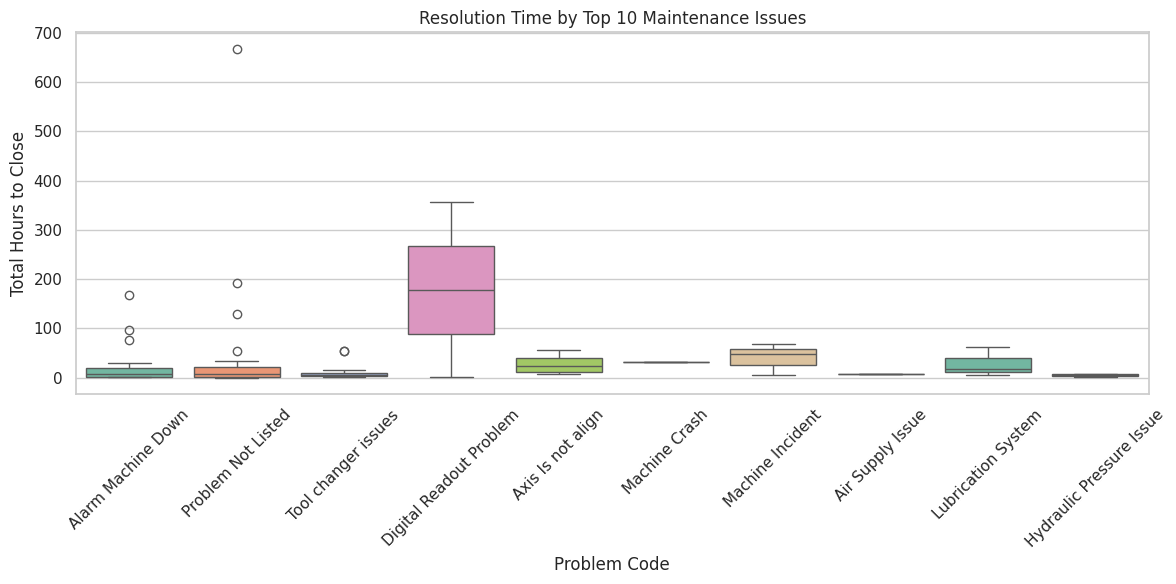

In [39]:
# Step 1: Compute median resolution time per problem code
top_problems = (
    df.groupby("MaintenanceProblemCode")["TotalHoursToClose"]
    .median()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# Step 2: Filter dataset
df_top = df[df["MaintenanceProblemCode"].isin(top_problems)]

# Step 3: Plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    x="MaintenanceProblemCode",
    y="TotalHoursToClose",
    data=df_top,
    palette="Set2"
)
plt.title("Resolution Time by Top 10 Maintenance Issues")
plt.ylabel("Total Hours to Close")
plt.xlabel("Problem Code")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
